In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/phyto_curves_reco

/content/gdrive/My Drive/phyto_curves_reco


#Load functions

In [2]:
!pip install tensorflow-addons
!pip install fastparquet

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 6.1 MB/s 
     |████████████████████████████████| 125 kB 57.7 MB/s 
     |████████████████████████████████| 1.5 MB 34.7 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=348185 sha256=6bf0f61571dbfebae090067ec89e088812e0f5900520ac15761600270a84bcb5
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift


In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import fastparquet as fp
import scipy.integrate as it
from collections import Counter

from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score

import tensorflow as tf
import os
import pickle
from collections import Counter
import pandas as pd
from keras.models import Model, load_model, model_from_json

from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

os.chdir('/content/gdrive/My Drive/phyto_curves_reco')
from pred_functions import predict, combine_files_into_acquisitions, post_processing
from dataset_preprocessing import homogeneous_cluster_names_swings, gen_train_test_valid
from losses import CB_loss, categorical_focal_loss


os.chdir('/content/gdrive/My Drive/data/SWINGS')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Représentation des jeux de train, valid et test

In [4]:
#importation data
dir = "/content/gdrive/MyDrive/data/SWINGS/L2/Pulse/"

# Load the raw data
train = np.load(dir + 'train.npz', allow_pickle = True)
valid = np.load(dir + 'valid.npz', allow_pickle = True)
test = np.load(dir + 'test.npz', allow_pickle = True)
tn = pd.read_csv(dir + 'train_test_nomenclature.csv')

# Dispatch the data

X_test = test['X']
X_valid = valid['X']
X_train = train['X']
y_train = train['y']


In [ ]:
X_train.shape

(44461, 120, 5)

## Perform the prediction over the test set

In [5]:
# Load the model 
model = load_model('/content/gdrive/My Drive/Models/SWINGS/cnn_small')

In [ ]:
model.load_weights('/content/gdrive/My Drive/phyto_curves_reco/w_categ_hyperopt2.hdf5')

In [6]:
train_rawpred = model.predict(X_train)
valid_rawpred = model.predict(X_valid)
test_rawpred = model.predict(X_test)

train_preds = pd.Series(train_rawpred.argmax(1)).astype(str)
preds_proba_train = pd.Series(train_rawpred.max(1)).astype(str)

valid_preds = pd.Series(valid_rawpred.argmax(1)).astype(str)
preds_proba_valid = pd.Series(valid_rawpred.max(1)).astype(str)

test_preds = pd.Series(test_rawpred.argmax(1)).astype(str)
preds_proba_test = pd.Series(test_rawpred.max(1)).astype(str)

In [7]:
del(train_rawpred)
del(valid_rawpred)
del(test_rawpred)

### Format consensual particles train / valid / test sets

In [8]:
# Compute the integrals for both sets 
train_it = pd.DataFrame(data = it.trapz(train['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])
valid_it = pd.DataFrame(data = it.trapz(valid['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])
test_it = pd.DataFrame(data = it.trapz(test['X'], axis = 1), columns = ['Total FWS', 'Total SWS', 'Total FLO', 'Total FLR',	'Total CURV'])

# Store the consensual class
y_train = pd.Series(train['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)
y_valid = pd.Series(valid['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)
y_test = pd.Series(test['y'].argmax(axis = 1), name = 'Pred FFT Label').astype(str)

# Turn numbers into class labels
for idx, row in tn.iterrows():
  y_train = y_train.str.replace(str(row['id']), row['name'])
  y_valid = y_valid.str.replace(str(row['id']), row['name'])
  y_test = y_test.str.replace(str(row['id']), row['name'])

  train_preds = train_preds.str.replace(str(row['id']), row['name'])
  valid_preds = valid_preds.str.replace(str(row['id']), row['name'])
  test_preds =  test_preds.str.replace(str(row['id']), row['name'])

# Add them as a column 
train_it['True FFT Label'] = y_train
train_it['Pred FFT Label'] = train_preds
train_it['Niveau confiance'] = preds_proba_train

valid_it['True FFT Label'] = y_valid
valid_it['Pred FFT Label'] = valid_preds
valid_it['Niveau confiance'] = preds_proba_valid

test_it['True FFT Label'] = y_test
test_it['Pred FFT Label'] = test_preds
test_it['Niveau confiance'] = preds_proba_test

In [9]:
del(train)
del(valid)
del(test)

## Display the performance

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9862939231639828
Classes accuracy:  {'MICRO': 0.7525773195876289, 'ORGNANO': 0.9629629629629629, 'ORGPICOPRO': 0.992388684510973, 'REDNANO': 0.8503737319807795, 'REDPICOEUK': 0.9965030704747051, 'REDPICOPRO': 0.9452710570578341, 'inf1microm': 0.9958803059236354, 'sup1microm': 0.9201991828396323}
Macro accuracy:  0.9270195394172689


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         219        0           0        0           0           0   
ORGNANO         1       78           0       25           0           0   
ORGPICOPRO      0        0       15646        0           0           0   
REDNANO        58        0           0     6371         197           0   
REDPICOEUK      0        1           6     1043       81785           0   
REDPICOPRO      0        0           4        0           0        7306   
inf1micro

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9880859718655967
Classes accuracy:  {'MICRO': 0.6445783132530121, 'ORGNANO': 0.5118483412322274, 'ORGPICOPRO': 0.9886986301369863, 'REDNANO': 0.8346119984907558, 'REDPICOEUK': 0.9946999411104568, 'REDPICOPRO': 0.6801935964259122, 'inf1microm': 0.9984203346018525, 'sup1microm': 0.8983503153808831}
Macro accuracy:  0.8189251838290108


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         214        1           0        3           0           0   
ORGNANO         1      108           0       15           0           0   
ORGPICOPRO      0       40       34644        0           0           0   
REDNANO        94        5           0     6636         205           0   
REDPICOEUK      0       20           0     1255       89522          14   
REDPICOPRO      0        0           3        0           0        1827   
inf1micr

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.985992443016948
Classes accuracy:  {'MICRO': 0.7157190635451505, 'ORGNANO': 0.5549738219895288, 'ORGPICOPRO': 0.9886418628483589, 'REDNANO': 0.727538112228349, 'REDPICOEUK': 0.9964612541135104, 'REDPICOPRO': 0.7205824478551751, 'inf1microm': 0.9989590330801852, 'sup1microm': 0.9085673146148309}
Macro accuracy:  0.8264303637843862


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         214        1           0        3           0           0   
ORGNANO         1      106           0       17           0           0   
ORGPICOPRO      0        0       34730        0           0           0   
REDNANO        64        4           0     6729         142           0   
REDPICOEUK      0       28           6     2443       88418          11   
REDPICOPRO      0        0           3        0           0        1831   
inf1microm

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9897888279518906
Classes accuracy:  {'MICRO': 0.8062015503875969, 'ORGNANO': 0.3515358361774744, 'ORGPICOPRO': 0.9925296239052035, 'REDNANO': 0.843446758959762, 'REDPICOEUK': 0.9923876348712517, 'REDPICOPRO': 0.7384105960264901, 'inf1microm': 0.9988223608081677, 'sup1microm': 0.9569173133529569}
Macro accuracy:  0.8350314593111129


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         208        2           0        8           0           0   
ORGNANO         3      103           0       19           0           0   
ORGPICOPRO      0        0       34677        0           0           0   
REDNANO        16       60           0     6519         345           0   
REDPICOEUK      0       27           8     1121       89952           5   
REDPICOPRO      0        0           1        0           0        1784   
inf1micro

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9900065310942714
Classes accuracy:  {'MICRO': 0.8706896551724138, 'ORGNANO': 0.5369458128078818, 'ORGPICOPRO': 0.9883207520296254, 'REDNANO': 0.8665501948662814, 'REDPICOEUK': 0.9915706194768275, 'REDPICOPRO': 0.7479338842975206, 'inf1microm': 0.9989708457497466, 'sup1microm': 0.935717988595127}
Macro accuracy:  0.867087469124428


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         202        2           0       14           0           0   
ORGNANO         1      109           0       14           0           0   
ORGPICOPRO      0        0       34695        0           5           0   
REDNANO        13       27           0     6448         452           0   
REDPICOEUK      0       42           8      892       89989          74   
REDPICOPRO      0        0           1        0           0        1810   
inf1microm

In [ ]:
set_ = valid_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9672606619453843
Classes accuracy:  {'MICRO': 0.6575840145322435, 'ORGNANO': 0.8483779971791255, 'ORGPICOPRO': 0.9870316645590022, 'REDNANO': 0.8224828934506354, 'REDPICOEUK': 0.9846192452869645, 'REDPICOPRO': 0.5506022740065293, 'inf1microm': 0.9965952221478008, 'sup1microm': 0.8410524241229799}
Macro accuracy:  0.8360432169106602


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         724       14           0       18           0           0   
ORGNANO        11     1203           0       35           1           0   
ORGPICOPRO      0        6       39806        0           0          27   
REDNANO       288      111           0    12621         508           0   
REDPICOEUK     27       16          11     2588       94168          47   
REDPICOPRO      0        0           2        0           1        4891   
inf1micr

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9920583086553402
Classes accuracy:  {'MICRO': 0.7068403908794788, 'ORGNANO': 0.5628415300546448, 'ORGPICOPRO': 0.9954124494652636, 'REDNANO': 0.8436578171091446, 'REDPICOEUK': 0.9946466098882867, 'REDPICOPRO': 0.8274296094459582, 'inf1microm': 0.9994373833209728, 'sup1microm': 0.9652432969215492}
Macro accuracy:  0.8619386358856623


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         217        0           0        1           0           0   
ORGNANO         1      103           0       20           0           0   
ORGPICOPRO      0        0       34717        0           0           0   
REDNANO        72        6           0     6578         284           0   
REDPICOEUK      1       30           5     1164       89926           0   
REDPICOPRO      0        0           2        0           0        1822   
inf1micr

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.991214336199261
Classes accuracy:  {'MICRO': 0.8359375, 'ORGNANO': 0.6258503401360545, 'ORGPICOPRO': 0.9921664275466284, 'REDNANO': 0.8820858558062741, 'REDPICOEUK': 0.9927153483868127, 'REDPICOPRO': 0.7834339948231234, 'inf1microm': 0.9996107155662551, 'sup1microm': 0.8904892546867855}
Macro accuracy:  0.8752861796189917


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         214        0           0        4           0           0   
ORGNANO         1       92           0       27           0           0   
ORGPICOPRO      0        0       34577        0           0           0   
REDNANO        33        4           0     6411         488           0   
REDPICOEUK      0       41           7      764       90214           2   
REDPICOPRO      0        0          12        0           0        1816   
inf1microm      0 

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

    

Evaluation of best performing model:
Micro accuracy:  0.9904300084397245
Classes accuracy:  {'MICRO': 0.8235294117647058, 'ORGNANO': 0.6011904761904762, 'ORGPICOPRO': 0.9933664532062143, 'REDNANO': 0.9239940387481371, 'REDPICOEUK': 0.9898434934880158, 'REDPICOPRO': 0.6985981308411215, 'inf1microm': 0.998371460615465, 'sup1microm': 0.9191919191919192}
Macro accuracy:  0.8685106730057568


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         210        3           0        5           0           0   
ORGNANO         0      101           0       16           2           0   
ORGPICOPRO      0        0       34592        0           0           1   
REDNANO        35       35           0     6200         670           0   
REDPICOEUK      0       22           4      445       90442          16   
REDPICOPRO      0        0           1        0           0        1794   
inf1micro

In [ ]:
set_ = valid_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9751483975344931
Classes accuracy:  {'MICRO': 0.8441247002398081, 'ORGNANO': 0.8557833089311859, 'ORGPICOPRO': 0.9938600702428178, 'REDNANO': 0.8997060984570169, 'REDPICOEUK': 0.9826531677277945, 'REDPICOPRO': 0.7561346775727601, 'inf1microm': 0.997146478919613, 'sup1microm': 0.7317525606903783}
Macro accuracy:  0.8826451328476719


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         704       14           0       30           0           0   
ORGNANO        12     1169           0       18           1           0   
ORGPICOPRO      0        0       39334        0           0          20   
REDNANO       101      152           0    12245        1105           0   
REDPICOEUK      1       12          11     1246       94148           1   
REDPICOPRO      0        0           2        0           0        3975   
inf1micro

In [ ]:
set_ = test_it
print("Evaluation of best performing model:")
class_accuracy = precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                  average = None)

print('Micro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'micro'))
print('Classes accuracy: ', dict(zip(tn['name'], class_accuracy)))
print('Macro accuracy: ', precision_score(set_['True FFT Label'], set_['Pred FFT Label'],\
                                average = 'macro'))

print('\n')
pd.set_option("display.max_rows", None, "display.max_columns", None) 
print(pd.DataFrame(confusion_matrix(set_['True FFT Label'], set_['Pred FFT Label']), index = tn['name'], columns =  tn['name']))

Evaluation of best performing model:
Micro accuracy:  0.9880624727607061
Classes accuracy:  {'MICRO': 0.675, 'ORGNANO': 0.8272727272727273, 'ORGPICOPRO': 0.996081143384048, 'REDNANO': 0.8194479297365119, 'REDPICOEUK': 0.994223178249878, 'REDPICOPRO': 0.5391211146838156, 'inf1microm': 0.9994860831311927, 'sup1microm': 0.9097013197499421}
Macro accuracy:  0.8450416870260145


name        MICRO  ORGNANO  ORGPICOPRO  REDNANO  REDPICOEUK  REDPICOPRO  \
name                                                                      
MICRO         216        0           0        2           0           0   
ORGNANO         3       91           0       28           0           0   
ORGPICOPRO      0        0       34568        0           0           0   
REDNANO        72        0           0     6531         337           0   
REDPICOEUK      8        8           5     1359       89667          47   
REDPICOPRO      0        0           0        0           0        1509   
inf1microm      0      

### Misclassification visualisation

In [ ]:
colors = {'ORGPICOPRO' : 'darkorange', 'REDPICOEUK': 'tomato', 'REDNANO': 'maroon', 'REDPICOPRO': 'red',\
          'REDMICRO' : 'darkblue', 'inf1microm': 'chocolate', 'sup1microm': 'peachpuff', 'ORGMICRO': 'gold',\
          'inf1microm_particle' : 'chocolate', 'sup1microm_particle': 'aquamarine',\
          'Non-consensual' : 'black', 'ORGNANO': 'chartreuse', 'MICRO' : 'mediumblue',\
          'Unassigned Particles' : 'lightgreen'}

# The quantities to plot
q1 = 'Total FWS'
q2 = 'Total FLR'
q3 = 'Total FLO'

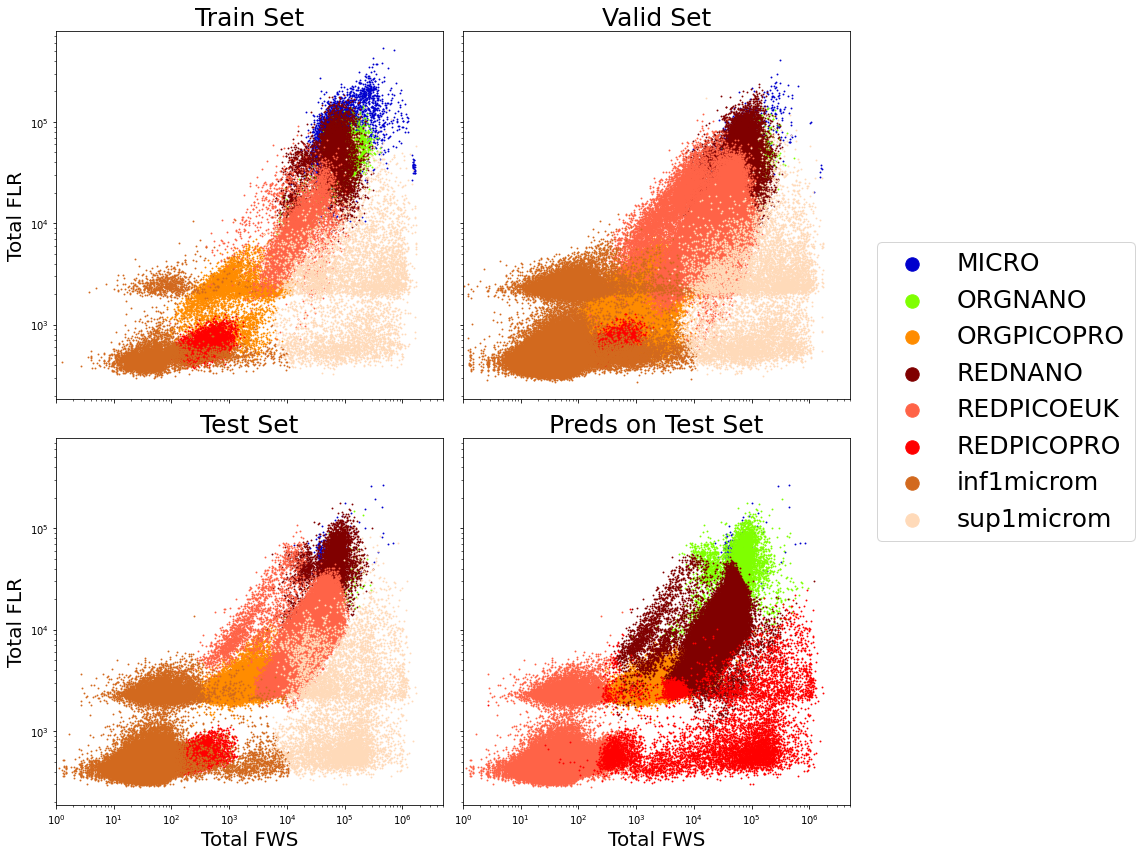

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 12))

# Train set
for idx, row in tn.iterrows():
  obs = train_it[train_it['True FFT Label'] == row['name']]
  axs[0,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Valid set
for idx, row in tn.iterrows():
  obs = valid_it[valid_it['True FFT Label'] == row['name']]
  axs[0,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['True FFT Label'] == row['name']]
  axs[1,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Preds on test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['Pred FFT Label'] == row['name']]
  axs[1,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Handling the titles
axs[0,0].set_title('Train Set', fontsize = 25)
axs[0,1].set_title('Valid Set', fontsize = 25)
axs[1,0].set_title('Test Set', fontsize = 25)
axs[1,1].set_title('Preds on Test Set', fontsize = 25)

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(q1, fontsize = 20)
    ax.set_ylabel(q2, fontsize = 20)
    ax.set_xlim (1,5*10**6)
    ax.label_outer()


fig.legend(tn['name'], markerscale = 15, bbox_to_anchor=(1,0.35), loc="lower left", fontsize = 25)
fig.tight_layout()
fig.show()

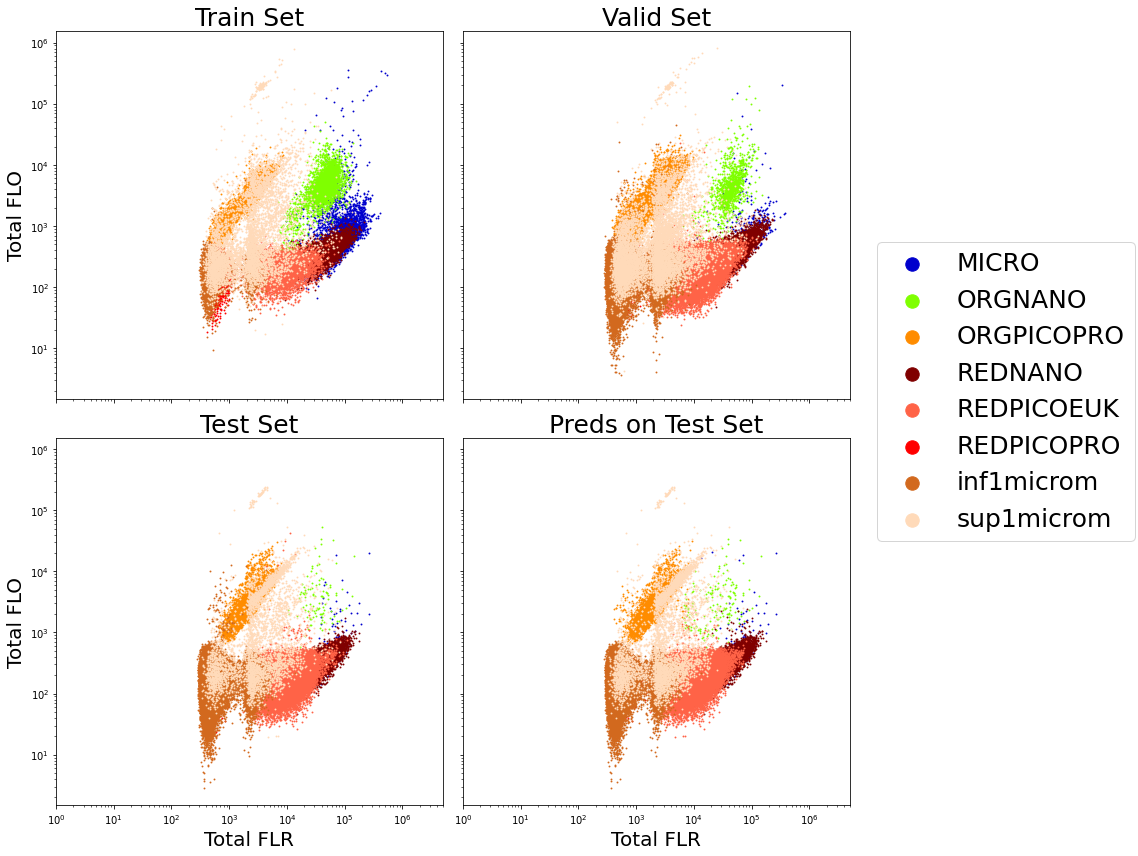

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (12, 12))

# Train set
for idx, row in tn.iterrows():
  obs = train_it[train_it['True FFT Label'] == row['name']]
  axs[0,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Valid set
for idx, row in tn.iterrows():
  obs = valid_it[valid_it['True FFT Label'] == row['name']]
  axs[0,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['True FFT Label'] == row['name']]
  axs[1,0].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Preds on test set
for idx, row in tn.iterrows():
  obs = test_it[test_it['Pred FFT Label'] == row['name']]
  axs[1,1].scatter(obs[q1], obs[q2], color = colors[row['name']], s = 0.8)

# Handling the titles
axs[0,0].set_title('Train Set', fontsize = 25)
axs[0,1].set_title('Valid Set', fontsize = 25)
axs[1,0].set_title('Test Set', fontsize = 25)
axs[1,1].set_title('Preds on Test Set', fontsize = 25)

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(q1, fontsize = 20)
    ax.set_ylabel(q2, fontsize = 20)
    ax.set_xlim (1,5*10**6)
    ax.label_outer()


fig.legend(tn['name'], markerscale = 15, bbox_to_anchor=(1,0.35), loc="lower left", fontsize = 25)
fig.tight_layout()
fig.show()

# Prediction confidence visualisation 

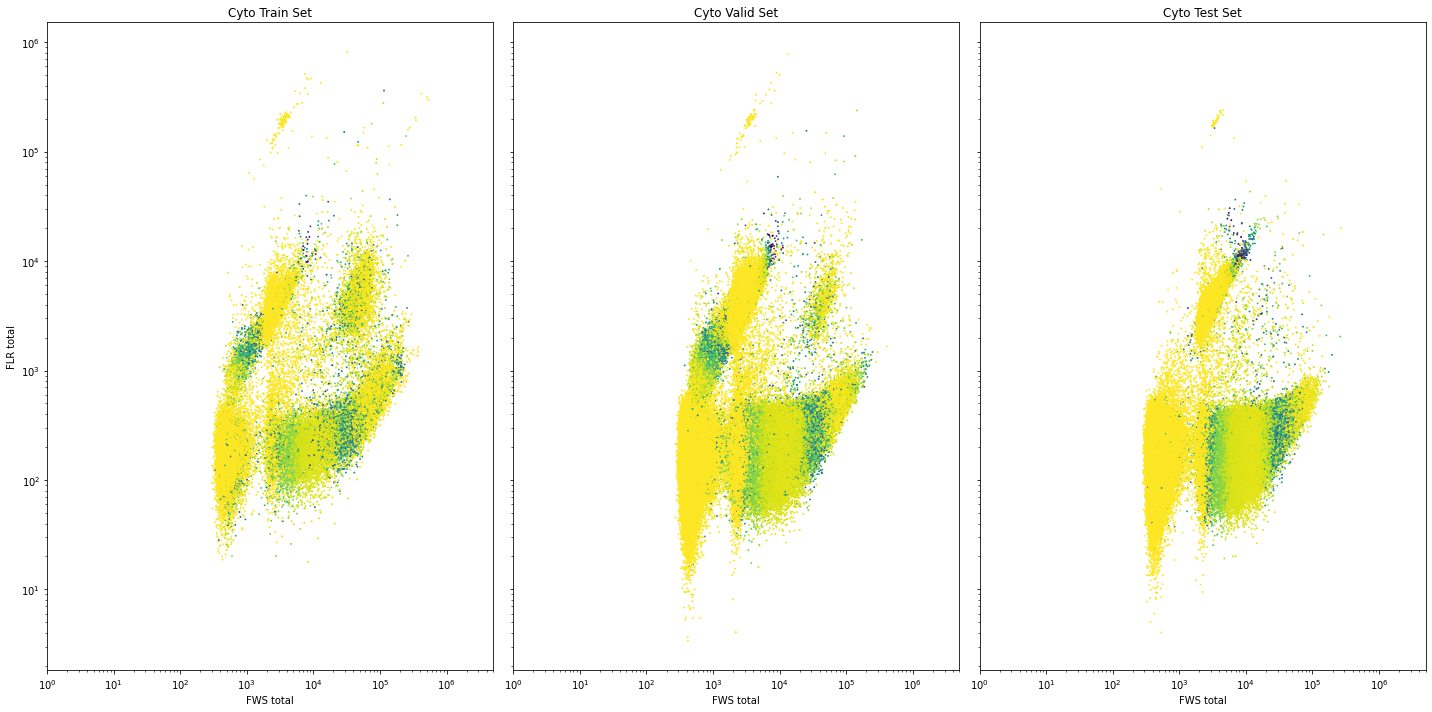

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

train_x = np.array(train_it['Total FLR'])
train_y = np.array(train_it['Total FLO'])
train_z = np.array(train_it['Niveau confiance'])

valid_x = np.array(valid_it['Total FLR'])
valid_y = np.array(valid_it['Total FLO'])
valid_z = np.array(valid_it['Niveau confiance'])


test_x = np.array(test_it['Total FLR'])
test_y = np.array(test_it['Total FLO'])
test_z = np.array(test_it['Niveau confiance'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
#plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SWINGS/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

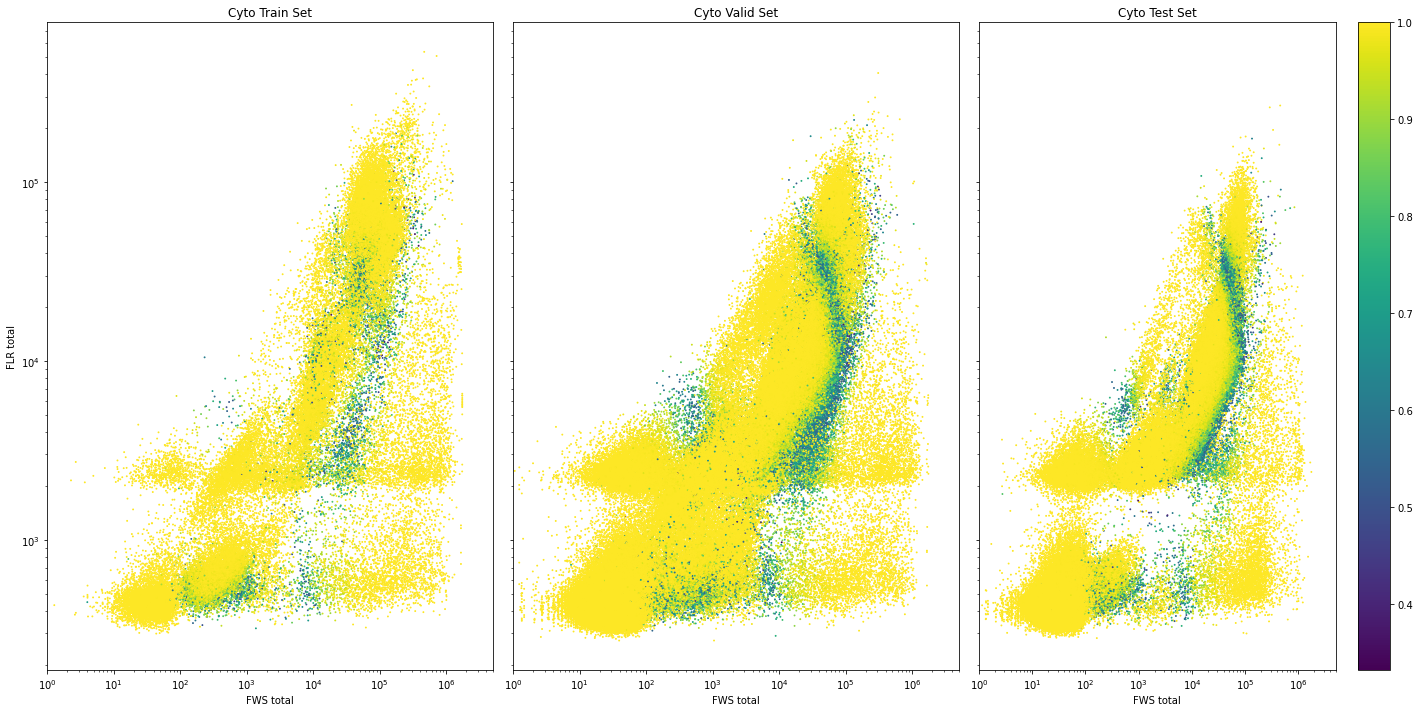

In [11]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

train_x = np.array(train_it['Total FWS'])
train_y = np.array(train_it['Total FLR'])
train_z = np.array(train_it['Niveau confiance'])

valid_x = np.array(valid_it['Total FWS'])
valid_y = np.array(valid_it['Total FLR'])
valid_z = np.array(valid_it['Niveau confiance'])


test_x = np.array(test_it['Total FWS'])
test_y = np.array(test_it['Total FLR'])
test_z = np.array(test_it['Niveau confiance'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SWINGS/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

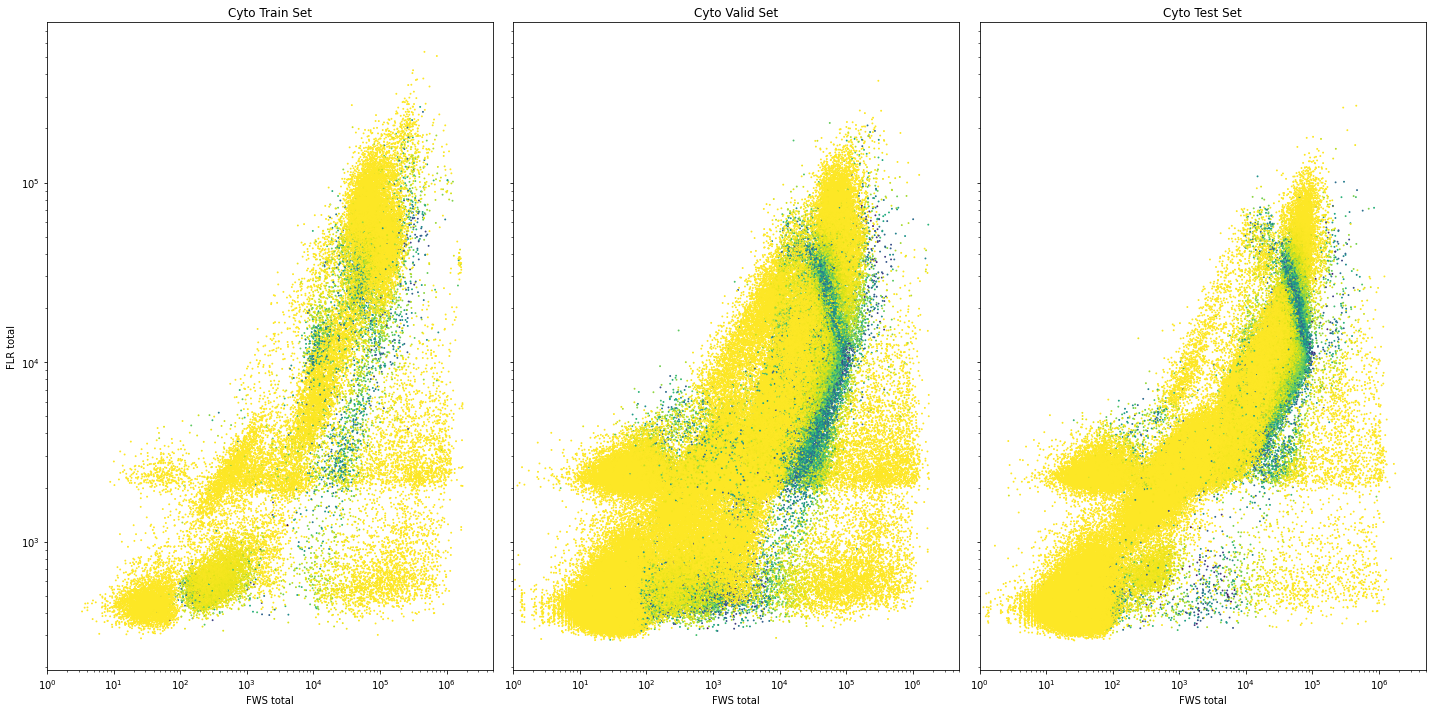

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

train_x = np.array(train_it['Total FWS'])
train_y = np.array(train_it['Total FLR'])
train_z = np.array(train_it['Niveau confiance'])

valid_x = np.array(valid_it['Total FWS'])
valid_y = np.array(valid_it['Total FLR'])
valid_z = np.array(valid_it['Niveau confiance'])


test_x = np.array(test_it['Total FWS'])
test_y = np.array(test_it['Total FLR'])
test_z = np.array(test_it['Niveau confiance'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
#plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SWINGS/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

# Plot misclassified points

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
train_it['Mispredicted'] = train_it['Pred FFT Label'] != train_it['True FFT Label']
valid_it['Mispredicted'] = valid_it['Pred FFT Label'] != valid_it['True FFT Label']
test_it['Mispredicted'] = test_it['Pred FFT Label'] != test_it['True FFT Label']

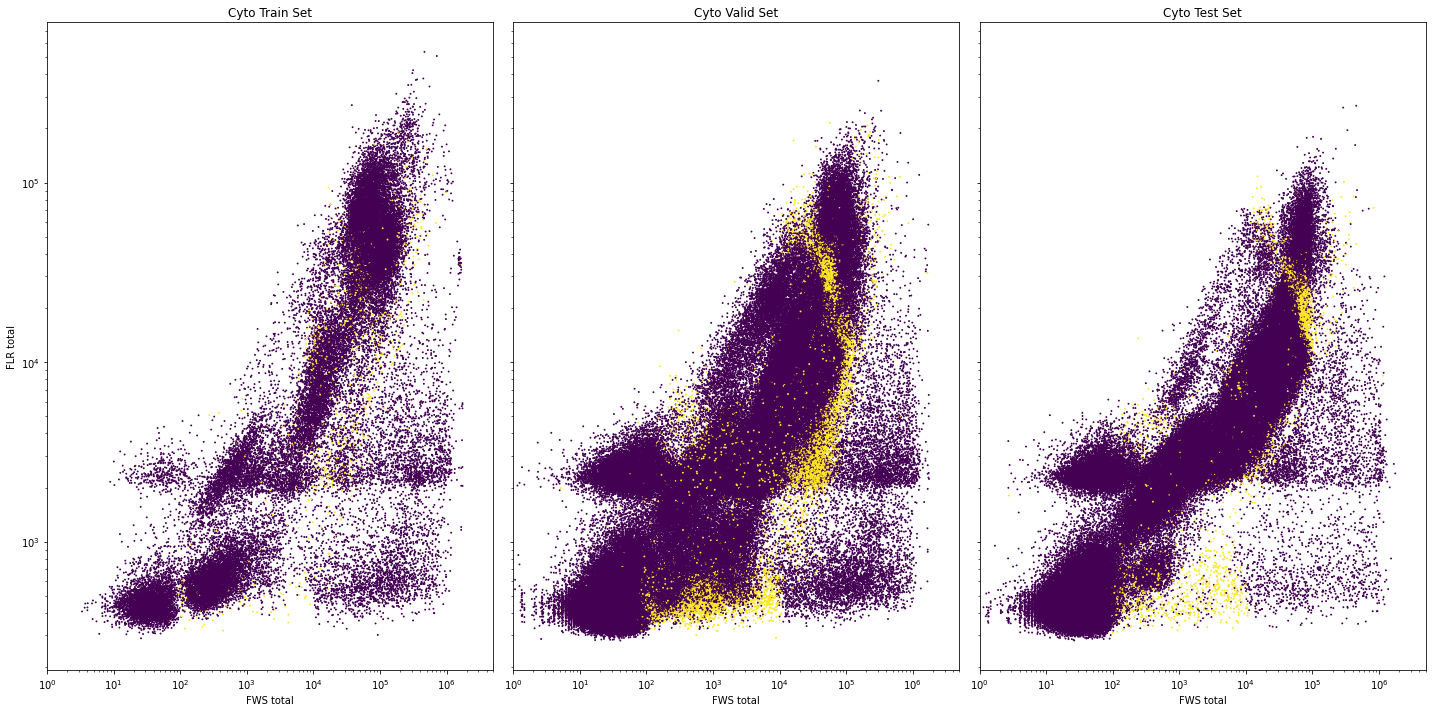

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20, 10), sharex = True, sharey = True)

#train_x = np.array(train_it['Total FWS'])
#train_y = np.array(train_it['Total FLR'])
train_z = np.array(train_it['Mispredicted'])

#valid_x = np.array(valid_it['Total FWS'])
#valid_y = np.array(valid_it['Total FLR'])
valid_z = np.array(valid_it['Mispredicted'])


#test_x = np.array(test_it['Total FWS'])
#test_y = np.array(test_it['Total FLR'])
test_z = np.array(test_it['Mispredicted'])

sc0 = axs[0].scatter(train_x, train_y, c = train_z.astype('float'),  s = 0.8, cmap = cm.viridis)
sc1 = axs[1].scatter(valid_x, valid_y, c = valid_z.astype('float'), s = 0.8, cmap = cm.viridis)
sc2 = axs[2].scatter(test_x, test_y, c = test_z.astype('float'),  s = 0.8, cmap = cm.viridis)


# Handling the titles
axs[0].set_title('Cyto Train Set')
axs[1].set_title('Cyto Valid Set')
axs[2].set_title('Cyto Test Set')

for ax in fig.get_axes():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(xlabel='FWS total', ylabel='FLR total')
    ax.set_xlim (1,5*10**6)
    ax.label_outer()

# The two colorbars (for each subplot) might differ slightly => uncomment to see
#plt.colorbar(sc0)
#plt.colorbar(sc1)
#plt.colorbar(sc2)

fig.tight_layout()
#fig.savefig('/content/gdrive/My Drive/data/SWINGS/cyto/train-test-valid/' + ' AllPlots_proba.png')
fig.show()

# Influence of the confidence level over the precision

In [ ]:
from copy import deepcopy
set_ = deepcopy(train_it)
X_set = deepcopy(train['X'])
set_['Niveau confiance'] = set_['Niveau confiance'].astype(float)

all_classes = set(set_['True FFT Label'])
class_ = 'REDPICOPRO'
other_classes = all_classes - set([class_])

0
{'MICRO': 0.87, 'ORGNANO': 0.96, 'ORGPICOPRO': 0.99, 'REDNANO': 0.88, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.73, 'inf1microm': 1.0, 'sup1microm': 0.79}
Share of the dataset kept 1.0
--------------------------
0.5
{'MICRO': 0.88, 'ORGNANO': 0.96, 'ORGPICOPRO': 0.99, 'REDNANO': 0.88, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.74, 'inf1microm': 1.0, 'sup1microm': 0.8}
Share of the dataset kept 0.998806896140309
--------------------------
0.7
{'MICRO': 0.93, 'ORGNANO': 0.99, 'ORGPICOPRO': 0.99, 'REDNANO': 0.93, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.83, 'inf1microm': 1.0, 'sup1microm': 0.88}
Share of the dataset kept 0.9757203364552884
--------------------------
0.8
{'MICRO': 0.95, 'ORGNANO': 0.99, 'ORGPICOPRO': 0.99, 'REDNANO': 0.96, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.86, 'inf1microm': 1.0, 'sup1microm': 0.92}
Share of the dataset kept 0.962161563306943
--------------------------
0.85
{'MICRO': 0.97, 'ORGNANO': 0.99, 'ORGPICOPRO': 0.99, 'REDNANO': 0.97, 'REDPICOEUK': 0.99, 'REDPICOPRO': 0.88, 'inf1

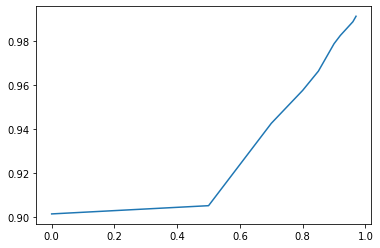

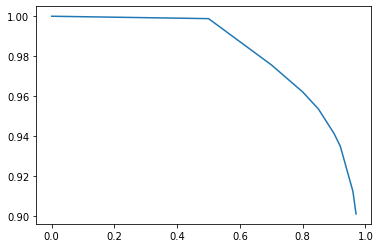

In [ ]:
perf = pd.DataFrame()

for thr in [0, 0.5, 0.70, 0.8, 0.85, 0.9, 0.92, 0.96, 0.97]:
  print(thr)
  purified_set = set_[set_['Niveau confiance'] >= thr]
  class_accuracy = precision_score(purified_set['True FFT Label'], purified_set['Pred FFT Label'], average = None)
  class_accuracy = [round(cc, 2) for cc in class_accuracy]
  print(dict(zip(tn['name'], class_accuracy)))
  print('Share of the dataset kept', len(purified_set) / len(set_))
  print('--------------------------')
  perf = perf.append({'thr': thr, 'class_accuracy': np.mean(class_accuracy), 'share kept': len(purified_set) / len(set_)}, ignore_index = True)

plt.plot(perf['thr'], perf['class_accuracy'])
plt.show()
plt.plot(perf['thr'], perf['share kept'])
plt.show()

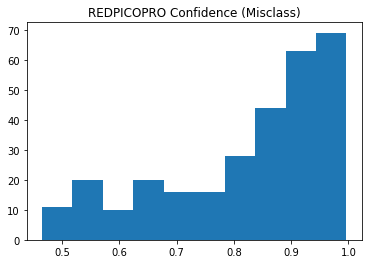

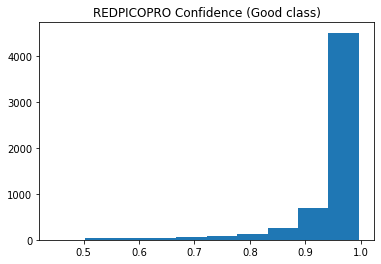

True FFT Label
ORGPICOPRO    0.692112
inf1microm    0.880842
Name: Niveau confiance, dtype: float64


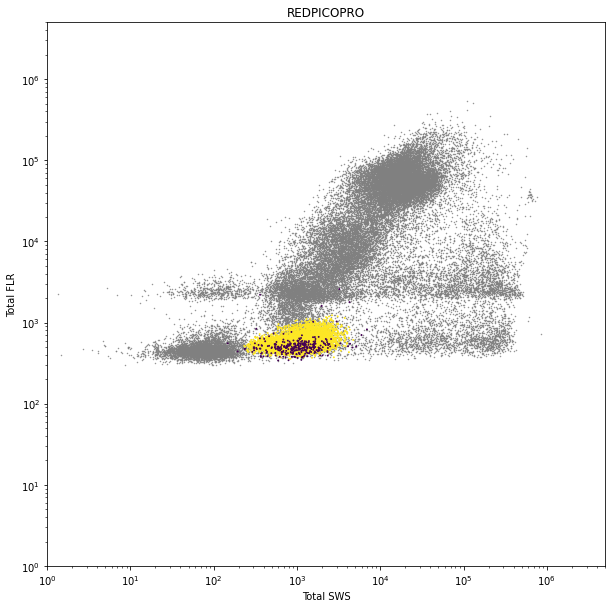

In [ ]:
q1 = 'Total SWS'
q1_curves = 1
q2 = 'Total FLR'
q2_curves = 3
q3 = 'Total FWS'
q3_curves = 0

#misclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'].isin(other_classes))]
misclass = set_[(set_['True FFT Label'].isin(other_classes)) & (set_['Pred FFT Label'] == class_ )]
goodclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'] == class_)]

plt.hist(misclass['Niveau confiance'].to_list())
plt.title(class_ + ' Confidence (Misclass)')
plt.show()
plt.title(class_ + ' Confidence (Good class)')
plt.hist(goodclass['Niveau confiance'].to_list())
plt.show()

# Confidence level when fail
print(misclass[['True FFT Label', 'Niveau confiance']].groupby(['True FFT Label'])['Niveau confiance'].median())

# Location in the plot
goodclass['right pred'] = 1
misclass['right pred'] = 0
allclass = goodclass.append(misclass)
otherclasses_idx = set(set_.index) - set(allclass.index)
otherclasses = set_.loc[otherclasses_idx]

plt.scatter(otherclasses[q1], otherclasses[q2], c = 'grey',  s = 0.2)
plt.scatter(allclass[q1], allclass[q2], c = allclass['right pred'],  s = 0.8, cmap = cm.viridis)
#plt.scatter(misclass[q1], misclass[q2], c = 'violet',  s = 0.8, cmap = cm.viridis)
#plt.scatter(goodclass[q1], goodclass[q2], c = 'yellow',  s = 0.8, cmap = cm.viridis)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(q1)
plt.ylabel(q2)
plt.title(class_)
plt.xlim(1,5*10**6)
plt.ylim(1,5*10**6)

fig = plt.gcf()
fig.set_size_inches(10, 10)

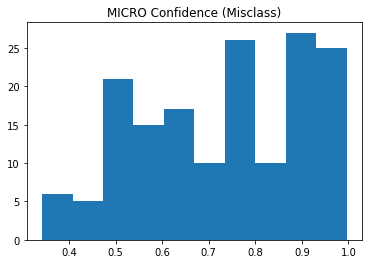

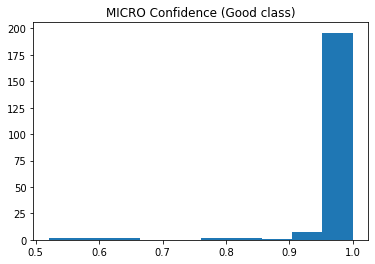

True FFT Label
ORGNANO       0.742259
REDNANO       0.754014
sup1microm    0.493699
Name: Niveau confiance, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


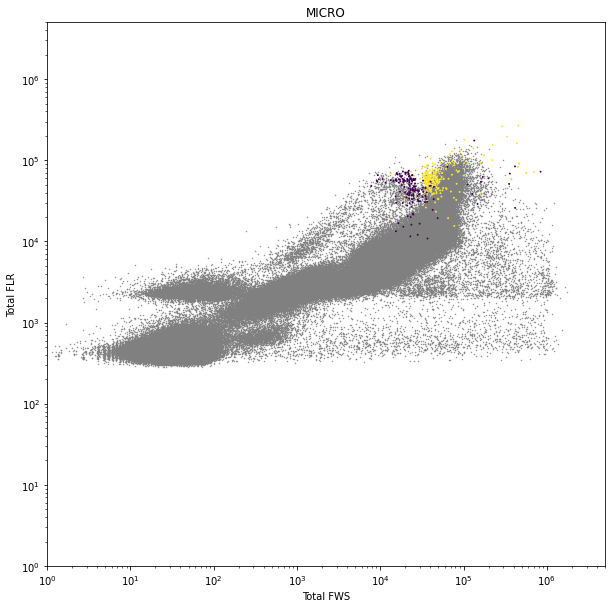

In [ ]:
all_classes = set(set_['True FFT Label'])
class_ = 'MICRO'
other_classes = all_classes - set([class_])

set_['Niveau confiance'] = set_['Niveau confiance'].astype(float)
q1 = 'Total FWS'
q1_curves = 0
q2 = 'Total FLR'
q2_curves = 3
q3 = 'Total FLO'
q3_curves = 2

#misclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'].isin(other_classes))]
misclass = set_[(set_['True FFT Label'].isin(other_classes)) & (set_['Pred FFT Label'] == class_ )]
goodclass = set_[(set_['True FFT Label'] == class_) & (set_['Pred FFT Label'] == class_)]

plt.hist(misclass['Niveau confiance'].to_list())
plt.title(class_ + ' Confidence (Misclass)')
plt.show()
plt.title(class_ + ' Confidence (Good class)')
plt.hist(goodclass['Niveau confiance'].to_list())
plt.show()

# Confidence level when fail
print(misclass[['True FFT Label', 'Niveau confiance']].groupby(['True FFT Label'])['Niveau confiance'].median())

# Location in the plot
goodclass['right pred'] = 1
misclass['right pred'] = 0
allclass = goodclass.append(misclass)
otherclasses_idx = set(set_.index) - set(allclass.index)
otherclasses = set_.loc[otherclasses_idx]

plt.scatter(otherclasses[q1], otherclasses[q2], c = 'grey',  s = 0.2)
plt.scatter(allclass[q1], allclass[q2], c = allclass['right pred'],  s = 0.8, cmap = cm.viridis)
#plt.scatter(misclass[q1], misclass[q2], c = 'violet',  s = 0.8, cmap = cm.viridis)
#plt.scatter(goodclass[q1], goodclass[q2], c = 'yellow',  s = 0.8, cmap = cm.viridis)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(q1)
plt.ylabel(q2)
plt.title(class_)
plt.xlim(1,5*10**6)
plt.ylim(1,5*10**6)

fig = plt.gcf()
fig.set_size_inches(10, 10)

# Plot outliers curves

In [ ]:
from scipy.stats import shapiro 

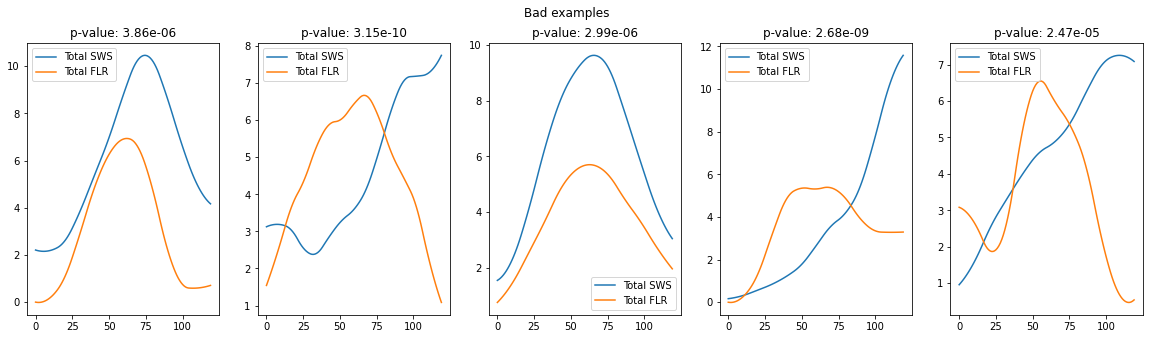

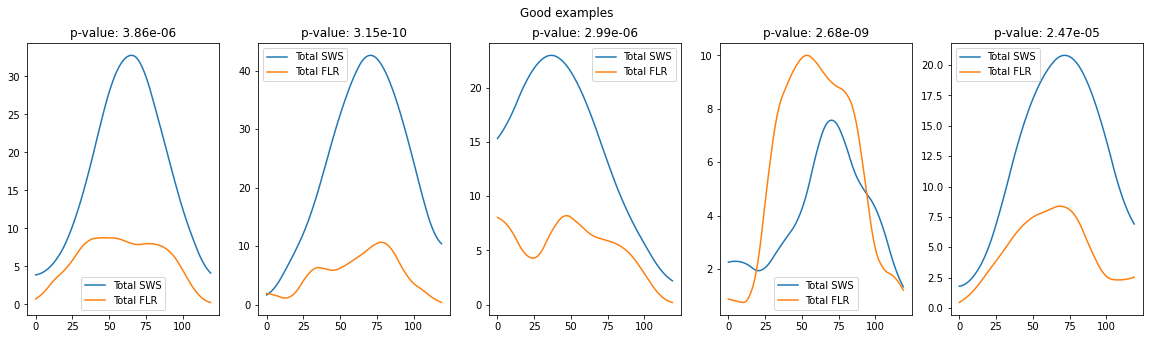

In [ ]:
nb_examples = 5

bad_examples_idx = misclass.sample(n = nb_examples).index
good_examples = goodclass.sample(n = nb_examples).index

# Fetch the curves
bad_examples = X_set[bad_examples_idx]
good_examples = X_set[good_examples]

fig, axs = plt.subplots(1, nb_examples, figsize = (20, 5), sharex = True)

for i in range(nb_examples):
  axs[i].plot(bad_examples[i,:,q1_curves], label = q1)
  axs[i].plot(bad_examples[i,:,q2_curves], label = q2)
  axs[i].set_title('p-value: ' + str("{:.2e}".format(shapiro(bad_examples[i,:,q1_curves])[1], 6)))
  axs[i].legend([q1, q2])

fig.suptitle('Bad examples')
plt.show()

fig, axs = plt.subplots(1, nb_examples, figsize = (20, 5), sharex = True)

for i in range(nb_examples):
  axs[i].plot(good_examples[i,:,q1_curves], label = q1)
  axs[i].plot(good_examples[i,:,q2_curves], label = q2)
  axs[i].legend([q1, q2])
  axs[i].set_title('p-value: ' + str("{:.2e}".format(shapiro(bad_examples[i,:,q1_curves])[1], 6)))
fig.suptitle('Good examples')
plt.show()

In [ ]:
def shapTest(x):
  x_pos = np.where(x <= 0, 1E-16, x)
  p = x_pos / x_pos.sum()
  draws = np.random.choice(a = range(len(x)), size = 120, p = p)
  return shapiro(draws)[1]

In [ ]:
set_SWS = X_set[:,:,1]
np.random.seed(seed=0)
shap = np.apply_along_axis(shapTest, 1, set_SWS)

14931


(array([32555.,  3390.,  2117.,  1572.,  1309.,  1058.,   826.,   715.,
          573.,   346.]),
 array([3.86423862e-23, 9.99861062e-02, 1.99972212e-01, 2.99958318e-01,
        3.99944425e-01, 4.99930531e-01, 5.99916637e-01, 6.99902743e-01,
        7.99888849e-01, 8.99874955e-01, 9.99861062e-01]),
 <a list of 10 Patch objects>)

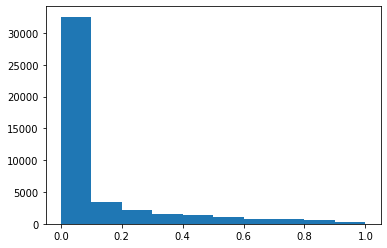

In [ ]:
good_idx = np.where(shap >= 0.05)[0]
shap_good = shap[good_idx]
print(len(good_idx))
plt.hist(shap)

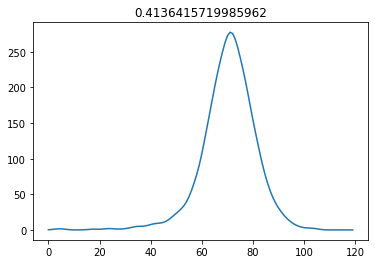

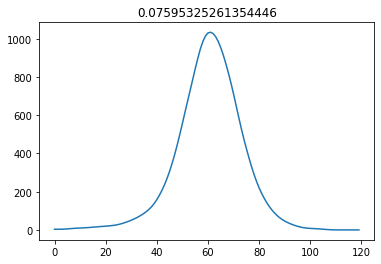

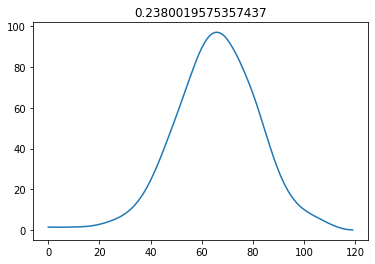

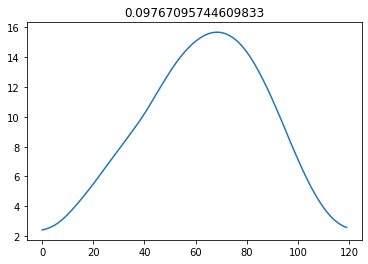

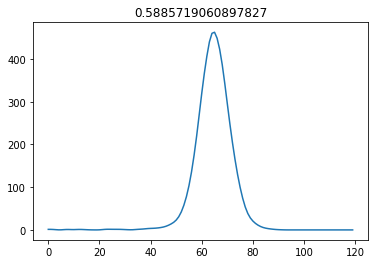

In [ ]:
indices = np.random.choice(good_idx, size = 5)
for i in indices:
  plt.plot(set_SWS[i])
  plt.title(shap[i])
  plt.show()

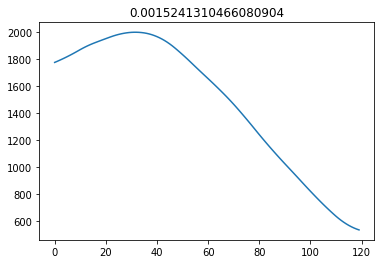

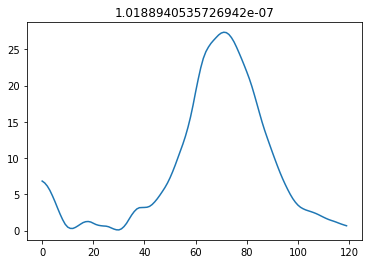

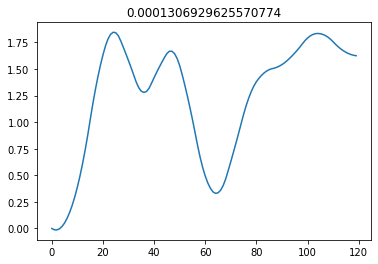

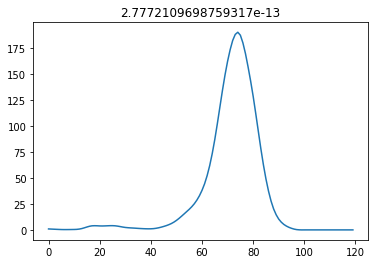

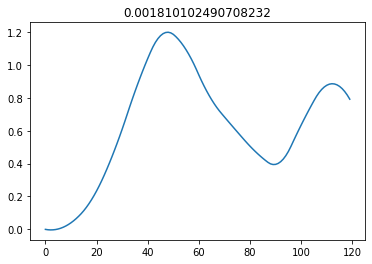

In [ ]:
indices = np.random.choice(list(set(range(len(shap))) - set(good_idx)), size = 5)
for i in indices:
  plt.plot(set_SWS[i])
  plt.title(shap[i])
  plt.show()

In [ ]:
shap.max()

0.9998610615730286

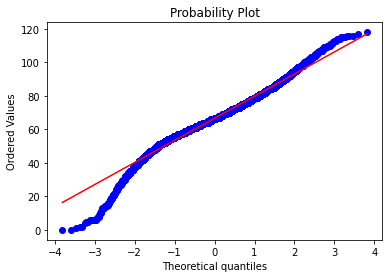

In [ ]:
import scipy.stats as stats
import pylab 
measurements = np.random.normal(loc = draws.mean(), scale = draws.std(), size=10000)   
stats.probplot(draws, dist="norm", plot=pylab)
pylab.show()